In [2]:
# !pip install --user nafflib

In [3]:
import traceback
import typing

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nafflib
import numpy as np
import pandas as pd
import sklearn.cluster

In [4]:
# Load dataframe
df2 = pd.read_parquet(
    "df_chroma_data_20250822_HV_dpp_pm4e-3_woMomentumRamp_MD1.parquet"
)

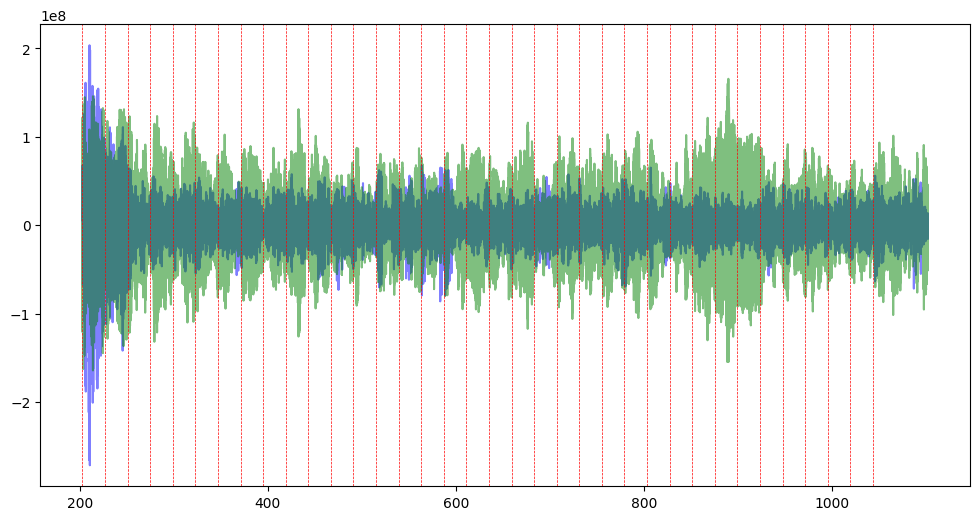

In [5]:
# Setting and checks
tune_lim = {"H": np.array([0.58, 0.645]), "V": np.array([0.54, 0.63])}
ms_ini = 200 + 3  # 10+3
chunk_size = 24  # in ms, check BBQ

N = 50  # Increased from 20 to capture more weak V tune peaks
total_duration = 1000 - ms_ini / 2
nr_of_chunks = int(total_duration / chunk_size) - 1

verbose = True  # to see the TbT slices

if verbose:
    i2look = 5
    row = df2.iloc[i2look]
    time_mask = (row["rawDataH_beamtime"] >= ms_ini) & (
        row["rawDataH_beamtime"] <= (ms_ini + total_duration)
    )
    rawDataH = row["rawDataH"][time_mask].astype(float)
    rawDataV = row["rawDataV"][time_mask].astype(float)
    rawDataH_ms = row["rawDataH_beamtime"][time_mask]
    rawDataV_ms = row["rawDataV_beamtime"][time_mask]

    f, ax = plt.subplots(figsize=(12, 6))
    ax.plot(rawDataH_ms, rawDataH, label="H", color="blue", alpha=0.5)
    ax.plot(rawDataV_ms, rawDataV, label="V", color="green", alpha=0.5)

    for i in range(nr_of_chunks):
        t_start = ms_ini + i * chunk_size
        t_end = t_start + chunk_size

        ax.axvline(x=t_start, color="red", linestyle="--", linewidth=0.5)

        # Select chunk
        maskH = rawDataH_ms >= t_start  # & (rawDataH_ms < t_end)
        maskV = rawDataV_ms >= t_start  # & (rawDataV_ms < t_end)
        tbtH = rawDataH[maskH][0:2000]
        tbtV = rawDataV[maskV][0:2000]
        # tbtH_time = rawDataV_ms[maskH][0:1980]
        # ax.plot(tbtH_time, tbtH, c='black')

In [6]:
# Loop to extract frequencies and amplitudes only (no tune identification yet)
average_tune_times_list = []
raw_frequencies_H_list = []
raw_amplitudes_H_list = []
raw_frequencies_V_list = []
raw_amplitudes_V_list = []


def sort_by_amplitude(Q: np.array, A: np.array) -> tuple[np.array, np.array]:
    sort_idx = np.argsort(np.abs(A))[::-1]
    return Q[sort_idx], A[sort_idx]


def sort_by_value(Q: np.array, A: np.array) -> tuple[np.array, np.array]:
    sort_idx = np.argsort(Q)[::-1]
    return Q[sort_idx], A[sort_idx]


def keep_valid(
    Q: np.array, A: np.array, lim: typing.Sequence
) -> tuple[np.array, np.array]:
    valid_idx = (lim[0] <= Q) & (lim[1] >= Q)
    return Q[valid_idx], A[valid_idx]


# Expanded tune limits for initial filtering (to catch coupled tunes)
expanded_tune_lim = {
    "H": np.array([0.54, 0.66]),  # Expanded to catch all potential tunes
    "V": np.array([0.54, 0.66]),  # Same range to catch coupled H tunes in V spectrum
}

for idx, row in df2.iterrows():
    print(f"{idx}/{len(df2)}")

    try:
        # Filter data starting from 200 ms
        time_mask = (row["rawDataH_beamtime"] >= ms_ini) & (
            row["rawDataH_beamtime"] <= (ms_ini + total_duration)
        )
        rawDataH = row["rawDataH"][time_mask].astype(float)
        rawDataV = row["rawDataV"][time_mask].astype(float)
        rawDataH_ms = row["rawDataH_beamtime"][time_mask]
        rawDataV_ms = row["rawDataV_beamtime"][time_mask]

        tune_times = []
        frequencies_H_chunks = []
        amplitudes_H_chunks = []
        frequencies_V_chunks = []
        amplitudes_V_chunks = []

        for i in range(nr_of_chunks):
            t_start = ms_ini + i * chunk_size
            t_end = t_start + chunk_size

            # Select chunk
            maskH = rawDataH_ms >= t_start  # & (rawDataH_ms < t_end)
            maskV = rawDataV_ms >= t_start  # & (rawDataV_ms < t_end)
            tbtH = rawDataH[maskH][0 : 990 * 2]  # selects 2 chunks (moving average)
            tbtV = rawDataV[maskV][0 : 990 * 2]  # selects 2 chunks (moving average)
            tbtH = tbtH - np.mean(tbtH)
            tbtV = tbtV - np.mean(tbtV)

            if len(tbtH) == 0 or len(tbtV) == 0:
                frequencies_H_chunks.append([])
                amplitudes_H_chunks.append([])
                frequencies_V_chunks.append([])
                amplitudes_V_chunks.append([])
                continue

            avg_time = np.mean([
                np.mean(rawDataH_ms[maskH][0:990]),
                np.mean(rawDataV_ms[maskV][0:990]),
            ])
            tune_times.append(avg_time)

            # Extract frequencies and amplitudes from both planes using EXPANDED limits
            chunk_freqs_H = []
            chunk_amps_H = []
            chunk_freqs_V = []
            chunk_amps_V = []

            try:
                QH, A, B = nafflib.get_tunes(tbtH, N=N, order=2)
                QH = 1 - QH
                QH_valid, AH_valid = keep_valid(
                    QH, A, expanded_tune_lim["H"]
                )  # Use expanded limits
                QH_valid, AH_valid = sort_by_amplitude(QH_valid, AH_valid)
                chunk_freqs_H = list(QH_valid)
                chunk_amps_H = list(AH_valid)
            except Exception:
                import traceback

                traceback.print_exc()

            try:
                QV, A, B = nafflib.get_tunes(tbtV, N=N, order=2)
                QV = 1 - QV
                QV_valid, AV_valid = keep_valid(
                    QV, A, expanded_tune_lim["V"]
                )  # Use expanded limits
                QV_valid, AV_valid = sort_by_amplitude(QV_valid, AV_valid)
                chunk_freqs_V = list(QV_valid)
                chunk_amps_V = list(AV_valid)
            except Exception:
                import traceback

                traceback.print_exc()

            # Store raw frequencies and amplitudes for this chunk
            frequencies_H_chunks.append(chunk_freqs_H)
            amplitudes_H_chunks.append(chunk_amps_H)
            frequencies_V_chunks.append(chunk_freqs_V)
            amplitudes_V_chunks.append(chunk_amps_V)

    except Exception as ex:
        print(f"Error in row {idx}: {ex}")
        print("Ignoring...")
        tune_times, frequencies_H_chunks, amplitudes_H_chunks = [], [], []
        frequencies_V_chunks, amplitudes_V_chunks = [], []

    average_tune_times_list.append(tune_times)
    raw_frequencies_H_list.append(frequencies_H_chunks)
    raw_amplitudes_H_list.append(amplitudes_H_chunks)
    raw_frequencies_V_list.append(frequencies_V_chunks)
    raw_amplitudes_V_list.append(amplitudes_V_chunks)

# Add raw data to DataFrame
df2["average_tune_times"] = average_tune_times_list
df2["raw_frequencies_H"] = raw_frequencies_H_list
df2["raw_amplitudes_H"] = raw_amplitudes_H_list
df2["raw_frequencies_V"] = raw_frequencies_V_list
df2["raw_amplitudes_V"] = raw_amplitudes_V_list

0/39
1/39
2/39
3/39
4/39
5/39
6/39
7/39
8/39
9/39
10/39
11/39
12/39
13/39
14/39
15/39
16/39
17/39
18/39
19/39
20/39
21/39
22/39
23/39
24/39
25/39
26/39
27/39
28/39
29/39
30/39
31/39
32/39
33/39
34/39
35/39
36/39
37/39
38/39


In [7]:
def cluster_single_plane(
    Q_valid: np.array, A_valid: np.array, min_cluster_separation: float = 0.02
) -> list:
    """
    Cluster tunes from a single plane using K-means.

    Returns:
        List of cluster info dicts with 'centroid', 'tunes', and 'amplitudes'
    """
    if len(Q_valid) == 0:
        return []

    if len(Q_valid) == 1:
        return [
            {
                "centroid": Q_valid[0],
                "tunes": [Q_valid[0]],
                "amplitudes": [abs(A_valid[0])],
            }
        ]

    # Apply K-means with 2 clusters, initialized at min/max to encourage separation
    cluster = sklearn.cluster.KMeans(
        n_clusters=2,
        random_state=42,
        init=np.array([[np.min(Q_valid)], [np.max(Q_valid)]]),
    )
    labels = cluster.fit_predict(Q_valid.reshape(-1, 1))
    centers = cluster.cluster_centers_.flatten()

    # Build cluster info
    cluster_info = []
    for label in np.unique(labels):
        cluster_mask = labels == label
        cluster_tunes = Q_valid[cluster_mask]
        cluster_amps = np.abs(A_valid[cluster_mask])
        centroid = centers[label]

        cluster_info.append({
            "centroid": centroid,
            "tunes": cluster_tunes,
            "amplitudes": cluster_amps,
        })

    # Sort by centroid frequency (low to high)
    return sorted(cluster_info, key=lambda x: x["centroid"])


def merge_close_clusters(clusters: list, min_separation: float) -> list:
    """
    Merge clusters that are closer than min_separation.

    Returns:
        Merged cluster list
    """
    if len(clusters) <= 1:
        return clusters

    centroids = [cluster["centroid"] for cluster in clusters]

    # Check if clusters are too close
    if np.diff(centroids)[0] < min_separation:
        # Merge into single cluster
        merged_cluster = {
            "centroid": np.mean(centroids),
            "tunes": np.concatenate([cluster["tunes"] for cluster in clusters]),
            "amplitudes": np.concatenate([
                cluster["amplitudes"] for cluster in clusters
            ]),
        }
        return [merged_cluster]

    return clusters


def select_cluster_for_plane(
    clusters: list,
    plane: str,
    other_plane_centroid: float | None = None,
    min_separation: float = 0.02,
) -> tuple[int, dict]:
    """
    Select which cluster should represent a plane (H or V).

    Returns:
        (cluster_index, cluster_dict) or (None, None) if no valid cluster
    """
    if not clusters:
        return None, None

    if len(clusters) == 1:
        cluster = clusters[0]
        # Check separation from other plane
        if (
            other_plane_centroid is not None
            and abs(cluster["centroid"] - other_plane_centroid) < min_separation
        ):
            return None, None
        return 0, cluster

    # Multiple clusters - choose based on plane preference
    if plane == "H":  # noqa: SIM108
        # H prefers higher frequency cluster
        cluster_idx = -1  # Last (highest) cluster
    else:
        # V prefers lower frequency cluster
        cluster_idx = 0  # First (lowest) cluster

    cluster = clusters[cluster_idx]

    # Check separation from other plane
    if (
        other_plane_centroid is not None
        and abs(cluster["centroid"] - other_plane_centroid) < min_separation
    ):
        return None, None

    return cluster_idx, cluster


def get_best_tune_from_cluster(cluster: dict) -> float:
    """
    Get the tune with highest amplitude from a cluster.
    """
    if not cluster or len(cluster["amplitudes"]) == 0:
        return np.nan

    best_idx = np.argmax(cluster["amplitudes"])
    return cluster["tunes"][best_idx]


def check_temporal_continuity(tune: float, prev_tune: float, max_change: float) -> bool:
    """
    Check if tune change is within acceptable limits.
    """
    if np.isnan(prev_tune) or np.isnan(tune):
        return True
    return abs(tune - prev_tune) <= max_change


def separate_tunes_with_independent_clustering(
    QH_valid: np.array,
    AH: np.array,
    QV_valid: np.array,
    AV: np.array,
    prev_QH: float = np.nan,
    prev_QV: float = np.nan,
    min_cluster_separation: float = 0.02,
    max_tune_change: float = 0.2,
) -> tuple[float, float]:
    """
    Main function: Separate H and V tunes using independent clustering.

    Algorithm:
    1. Cluster each plane independently
    2. Merge clusters that are too close together
    3. Select appropriate cluster for each plane (H=higher, V=lower)
    4. Extract best tune (highest amplitude) from each selected cluster
    5. Apply temporal continuity constraints
    """

    # Step 1: Cluster each plane independently
    h_clusters = cluster_single_plane(QH_valid, AH, min_cluster_separation)
    v_clusters = cluster_single_plane(QV_valid, AV, min_cluster_separation)

    # Step 2: Merge clusters that are too close
    h_clusters = merge_close_clusters(h_clusters, min_cluster_separation)
    v_clusters = merge_close_clusters(v_clusters, min_cluster_separation)

    # Step 3: Select clusters for each plane
    # First pass - select without considering other plane
    _h_cluster_idx, h_cluster = select_cluster_for_plane(h_clusters, "H")
    _v_cluster_idx, v_cluster = select_cluster_for_plane(v_clusters, "V")

    # Second pass - check cross-plane separation
    h_centroid = h_cluster["centroid"] if h_cluster else None
    v_centroid = v_cluster["centroid"] if v_cluster else None

    # Re-select H considering V cluster
    if h_cluster and v_centroid:
        _h_cluster_idx, h_cluster = select_cluster_for_plane(
            h_clusters, "H", v_centroid, min_cluster_separation
        )

    # Re-select V considering H cluster
    if v_cluster and h_centroid:
        _v_cluster_idx, v_cluster = select_cluster_for_plane(
            v_clusters, "V", h_centroid, min_cluster_separation
        )

    # Step 4: Extract best tunes from selected clusters
    selected_QH = get_best_tune_from_cluster(h_cluster)
    selected_QV = get_best_tune_from_cluster(v_cluster)

    # Step 5: Apply temporal continuity constraints
    if not check_temporal_continuity(selected_QH, prev_QH, max_tune_change):
        selected_QH = np.nan
    if not check_temporal_continuity(selected_QV, prev_QV, max_tune_change):
        selected_QV = np.nan

    return selected_QH, selected_QV

In [8]:
# Secondary analysis: Tune identification from raw frequencies and amplitudes
calculated_QH_list = []
calculated_QV_list = []

print("Starting tune identification analysis...")

for idx in range(len(df2)):
    print(f"Processing tune identification for row {idx}/{len(df2)}")

    try:
        # Get raw data for this measurement
        tune_times = df2.iloc[idx]["average_tune_times"]
        raw_freqs_H = df2.iloc[idx]["raw_frequencies_H"]
        raw_amps_H = df2.iloc[idx]["raw_amplitudes_H"]
        raw_freqs_V = df2.iloc[idx]["raw_frequencies_V"]
        raw_amps_V = df2.iloc[idx]["raw_amplitudes_V"]

        QH_list = []
        QV_list = []

        # Initialize previous tunes for temporal continuity
        prev_QH = np.nan
        prev_QV = np.nan

        # Process each chunk
        for i in range(len(tune_times)):
            if i < len(raw_freqs_H) and i < len(raw_freqs_V):
                # Get frequencies and amplitudes for this chunk
                chunk_freqs_H = (
                    np.array(raw_freqs_H[i]) if raw_freqs_H[i] else np.array([])
                )
                chunk_amps_H = (
                    np.array(raw_amps_H[i]) if raw_amps_H[i] else np.array([])
                )
                chunk_freqs_V = (
                    np.array(raw_freqs_V[i]) if raw_freqs_V[i] else np.array([])
                )
                chunk_amps_V = (
                    np.array(raw_amps_V[i]) if raw_amps_V[i] else np.array([])
                )

                valid_H_idx = (chunk_freqs_H > tune_lim["H"][0]) & (
                    chunk_freqs_H < tune_lim["H"][1]
                )
                valid_V_idx = (chunk_freqs_V > tune_lim["V"][0]) & (
                    chunk_freqs_V < tune_lim["V"][1]
                )

                # Apply tune identification algorithm
                selected_QH, selected_QV = separate_tunes_with_independent_clustering(
                    chunk_freqs_H[valid_H_idx],
                    chunk_amps_H[valid_H_idx],
                    chunk_freqs_V[valid_V_idx],
                    chunk_amps_V[valid_V_idx],
                    prev_QH=prev_QH,
                    prev_QV=prev_QV,
                    min_cluster_separation=0.008,
                    max_tune_change=0.02,
                )

                QH_list.append(selected_QH)
                QV_list.append(selected_QV)

                # Update previous tunes for next iteration
                if not np.isnan(selected_QH):
                    prev_QH = selected_QH
                if not np.isnan(selected_QV):
                    prev_QV = selected_QV
            else:
                QH_list.append(np.nan)
                QV_list.append(np.nan)

    except Exception as ex:
        print(f"Error in tune identification for row {idx}: {ex}")
        traceback.print_exc()
        QH_list = [np.nan] * len(tune_times) if tune_times else []
        QV_list = [np.nan] * len(tune_times) if tune_times else []

    calculated_QH_list.append(QH_list)
    calculated_QV_list.append(QV_list)

# Add identified tunes to DataFrame
df2["calculated_QH"] = calculated_QH_list
df2["calculated_QV"] = calculated_QV_list

print("Tune identification complete!")

Starting tune identification analysis...
Processing tune identification for row 0/39
Processing tune identification for row 1/39
Processing tune identification for row 2/39
Processing tune identification for row 3/39
Processing tune identification for row 4/39
Processing tune identification for row 5/39
Processing tune identification for row 6/39
Processing tune identification for row 7/39
Processing tune identification for row 8/39
Processing tune identification for row 9/39
Processing tune identification for row 10/39
Processing tune identification for row 11/39
Processing tune identification for row 12/39
Processing tune identification for row 13/39
Processing tune identification for row 14/39
Processing tune identification for row 15/39
Processing tune identification for row 16/39
Processing tune identification for row 17/39
Processing tune identification for row 18/39
Processing tune identification for row 19/39
Processing tune identification for row 20/39
Processing tune identifi

In [9]:
df2[["calculated_QH", "calculated_QV"]]

calculated_QH  \
0   [0.6426877303933608, 0.644532790450622, 0.6371...   
1   [0.6437207106895384, 0.6374839408949203, nan, ...   
2   [0.6439166094132667, 0.640889926715277, 0.6398...   
3   [0.6364083980267936, 0.6405513622224077, nan, ...   
4   [0.6399371145338231, 0.6368858962665211, 0.640...   
5   [0.6381099766957861, 0.6382282300665822, nan, ...   
6   [0.6369053041823363, 0.6335659543842707, 0.637...   
7   [0.6378880218149697, 0.63948472497214, 0.63525...   
8   [0.634288876939986, 0.6344491790247304, 0.6347...   
9   [0.6329177521568411, 0.6372890134312257, 0.631...   
10  [0.6321742328472222, 0.6348438910837679, 0.632...   
11  [0.6349891279022506, 0.6321916206204266, 0.630...   
12  [0.6313467128860215, 0.6294581089356999, 0.629...   
13  [0.6280943131106552, 0.6322298703199276, 0.629...   
14  [0.6310733443389643, 0.6286970262294224, 0.630...   
15  [0.6310621557314282, 0.6287194225954394, nan, ...   
16  [0.6324400580274327, 0.629262869295689, 0.6273...   
17  [nan, 0.6329273252737027, 0.6311862060455276, ...   
18  [0.6258878200364741, 0.6263953785319744, 0.630...   
19  [0.6306234837715947, 0.626324701115037, 0.6257...   
20  [0.6295070151531386, 0.625503285687651, 0.6247...   
21  [0.6292120129946169, nan, 0.6278613264479022, ...   
22  [0.6287457308067859, 0.6254674280269812, 0.628...   
23  [0.6276139275427348, 0.6308651251777553, 0.634...   
24  [0.6414822656794954, 0.6329273433823175, 0.630...   
25  [0.6282009178895365, 0.6396667639319353, 0.622...   
26  [0.627552833614209, 0.6263785988815971, 0.6275...   
27  [0.6401550112409876, 0.6262690031584519, 0.622...   
28  [0.6225290500464724, 0.6259367407810787, nan, ...   
29  [0.6237082476787028, 0.6281712995413586, 0.625...   
30  [0.6224731488978001, 0.6245887631463547, 0.625...   
31  [0.6278609981506376, 0.6255785126224218, 0.621...   
32  [0.622532438125481, 0.6245127807010344, nan, 0...   
33  [0.6272707129378317, 0.6245656688730332, 0.624...   
34  [0.6248126165791889, 0.627786881624093, 0.6263...   
35  [0.6309638646544727, 0.6274963338074688, 0.622...   
36  [0.6301843676089599, 0.6253093128486569, 0.625...   
37  [0.6253428160829289, 0.6259343397308113, 0.620...   
38  [nan, 0.6369947299072329, 0.6236129110997606, ...   

                                        calculated_QV  
0   [0.5943868598380668, 0.587386121647335, 0.5951...  
1   [0.5980708649730777, 0.594520090449091, 0.5897...  
2   [0.596284171676368, 0.5932010385520786, 0.5954...  
3   [0.5886931408388818, 0.5902151263250613, 0.587...  
4   [0.5882522105402208, 0.5915890477448222, 0.585...  
5   [0.595973019588141, 0.5909276096608234, 0.5934...  
6   [0.5924956967641241, 0.5861205273680992, 0.580...  
7   [0.5921710589966704, 0.5920535886936096, 0.588...  
8   [0.5875220944659005, 0.591984564872451, 0.5917...  
9   [0.5882754815786324, 0.583996027801412, 0.5843...  
10  [0.5854540103465453, 0.5832373450508475, 0.586...  
11  [0.5867604386480749, nan, 0.5844832810004044, ...  
12  [0.5806709365520446, 0.5840460474535285, 0.579...  
13  [0.5810301036072053, 0.5801818265967233, 0.584...  
14  [0.5814638553551903, 0.5853105776700217, 0.580...  
15  [0.5784376396204951, 0.5767176712639019, nan, ...  
16  [0.5823298715960094, 0.577286302482225, 0.5815...  
17  [0.5794339188603199, 0.576091248278433, 0.5794...  
18  [0.577465712851944, 0.579161203330179, 0.57863...  
19  [0.5744630739730817, 0.5788050418670555, 0.569...  
20  [0.5733704372425932, 0.5765963790483263, 0.580...  
21  [0.5734870374280794, nan, 0.5749668600414368, ...  
22  [0.571927697483275, 0.5712336411596792, 0.5717...  
23  [0.5731381659253805, 0.5723026316640314, 0.571...  
24  [0.5694010875382649, 0.571117953664156, 0.5693...  
25  [0.5652449156562604, 0.5676176744386039, 0.569...  
26  [0.5670096690030364, 0.5685865105629542, 0.571...  
27  [0.567757669905465, 0.5649858171567144, 0.5661...  
28  [0.5693632957690716, 0.5646341475906629, 0.563...  
29  [0.5688702857177934, 0.5664799925769611, 0.564...  
30  [0.5602900390217213

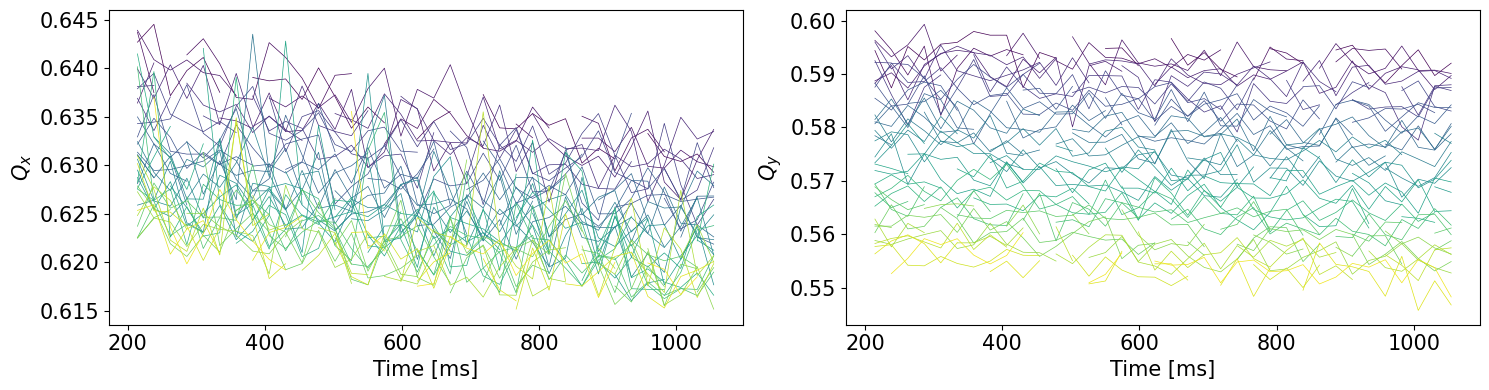

In [10]:
# Plot tune vs time
f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"Time [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
for i in range(len(df2)):
    ax.plot(
        df2.iloc[i]["average_tune_times"],
        df2.iloc[i]["calculated_QH"],
        linewidth=0.5,
        c=cm.viridis(i / len(df2)),
    )

ax = axs[1]
ax.set_xlabel(r"Time [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
for i in range(len(df2)):
    ax.plot(
        df2.iloc[i]["average_tune_times"],
        df2.iloc[i]["calculated_QV"],
        linewidth=0.5,
        c=cm.viridis(i / len(df2)),
    )

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"tune_evolution_20250822_HV_dpp_pm4e-3_MD1.{ext}", dpi=300)

## Average chroma along flat-bottom

In [11]:
df2["average_QH"] = (
    df2["calculated_QH"].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan) + 26
)
df2["average_QV"] = (
    df2["calculated_QV"].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan) + 26
)
df2["std_QH"] = df2["calculated_QH"].apply(
    lambda x: np.nanstd(x) if len(x) > 0 else np.nan
)
df2["std_QV"] = df2["calculated_QV"].apply(
    lambda x: np.nanstd(x) if len(x) > 0 else np.nan
)

In [12]:
degree = 3

idx = (
    np.isfinite(df2["dp_over_p"])
    & np.isfinite(df2["average_QH"])
    & np.isfinite(df2["std_QH"])
    & (df2["std_QH"] > 0)
)
coeffs_H, cov_H = np.polyfit(
    df2["dp_over_p"][idx],
    df2["average_QH"][idx],
    degree,
    cov="unscaled",
    w=1 / df2["std_QH"][idx],
)  # Polynomial coefficients, highest power first.
err_H = np.sqrt(np.diag(cov_H))
linear_chroma_H = coeffs_H[-2]
linear_chroma_H_err = err_H[-2]
second_order_chroma_H = coeffs_H[-3] * 2 * 1
second_order_chroma_H_err = err_H[-3] * 2 * 1
third_order_chroma_H = coeffs_H[-4] * 3 * 2 * 1
third_order_chroma_H_err = err_H[-4] * 3 * 2 * 1
poly_H = np.poly1d(coeffs_H)

idx = (
    np.isfinite(df2["dp_over_p"])
    & np.isfinite(df2["average_QV"])
    & np.isfinite(df2["std_QV"])
    & (df2["std_QV"] > 0)
)
coeffs_V, cov_V = np.polyfit(
    df2["dp_over_p"][idx],
    df2["average_QV"][idx],
    degree,
    cov="unscaled",
    w=1 / df2["std_QV"][idx],
)
err_V = np.sqrt(np.diag(cov_V))
linear_chroma_V = coeffs_V[-2]
linear_chroma_V_err = err_V[-2]
second_order_chroma_V = coeffs_V[-3] * 2 * 1
second_order_chroma_V_err = err_V[-3] * 2 * 1
third_order_chroma_V = coeffs_V[-4] * 3 * 2 * 1
third_order_chroma_V_err = err_V[-4] * 3 * 2 * 1
poly_V = np.poly1d(coeffs_V)

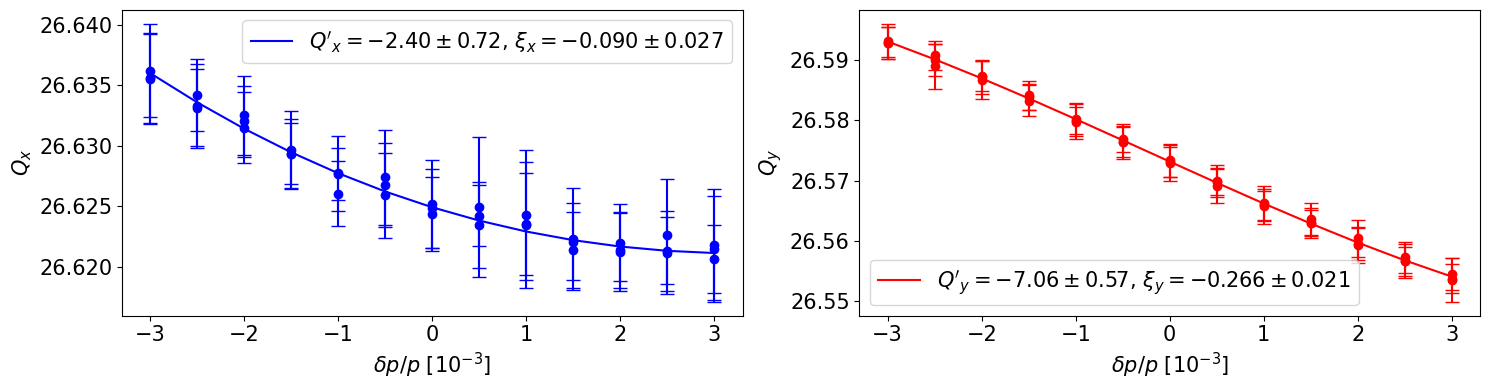

In [13]:
dppsorted = np.sort(np.unique(df2["dp_over_p"]))

qx0, qy0 = coeffs_H[-1], coeffs_V[-1]  # 26.621, 26.581

f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"$\delta p/p$ [$10^{-3}$]", fontsize=fontsize)
ax.set_ylabel(r"$Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df2["dp_over_p"] * 1000,
    df2["average_QH"],
    yerr=df2["std_QH"],
    fmt="o",
    capsize=5,
    color="blue",
)
ax.plot(
    dppsorted * 1000,
    poly_H(dppsorted),
    color="blue",
    label=rf"$Q'_x = {linear_chroma_H:1.2f} \pm {linear_chroma_H_err:1.2f}$, $\xi_x = {linear_chroma_H / qx0:1.3f} \pm {linear_chroma_H_err / qx0:1.3f}$",
)
ax.legend(fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$\delta p/p$ [$10^{-3}$]", fontsize=fontsize)
ax.set_ylabel(r"$Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df2["dp_over_p"] * 1000,
    df2["average_QV"],
    yerr=df2["std_QV"],
    fmt="o",
    capsize=5,
    color="red",
)
ax.plot(
    dppsorted * 1000,
    poly_V(dppsorted),
    color="red",
    label=rf"$Q'_y = {linear_chroma_V:1.2f} \pm {linear_chroma_V_err:1.2f}$, $\xi_y = {linear_chroma_V / qy0:1.3f} \pm {linear_chroma_V_err / qy0:1.3f}$",
)
ax.legend(fontsize=fontsize)

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"chromas_20250822_HV_dpp_pm4e-3_MD1.{ext}", dpi=300)

In [14]:
# Check average chromas
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Linear chroma H: {linear_chroma_H:.3f} ± {linear_chroma_H_err:.3f}, normalized: {linear_chroma_H / qx0:.3f} ± {linear_chroma_H_err / qx0:.3f}"
)
print(
    f"Linear chroma V: {linear_chroma_V:.3f} ± {linear_chroma_V_err:.3f}, normalized: {linear_chroma_V / qy0:.3f} ± {linear_chroma_V_err / qy0:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Second order chroma H [1e3]: {second_order_chroma_H * 1e-3:.3f} ± {second_order_chroma_H_err * 1e-3:.3f}"
)
print(
    f"Second order chroma V [1e3]: {second_order_chroma_V * 1e-3:.3f} ± {second_order_chroma_V_err * 1e-3:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Third order chroma H [1e6]: {third_order_chroma_H * 1e-6:.3f} ± {third_order_chroma_H_err * 1e-6:.3f}"
)
print(
    f"Third order chroma V [1e6]: {third_order_chroma_V * 1e-6:.3f} ± {third_order_chroma_V_err * 1e-6:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print("QPH in LSA: 0.6003")
print("QP in LSA: -0.7258")

~*~*~*~*~*~*~*~*~*~*~*~*
Linear chroma H: -2.399 ± 0.715, normalized: -0.090 ± 0.027
Linear chroma V: -7.059 ± 0.567, normalized: -0.266 ± 0.021
~*~*~*~*~*~*~*~*~*~*~*~*
Second order chroma H [1e3]: 0.812 ± 0.362
Second order chroma V [1e3]: 0.093 ± 0.275
~*~*~*~*~*~*~*~*~*~*~*~*
Third order chroma H [1e6]: -0.052 ± 0.661
Third order chroma V [1e6]: 0.373 ± 0.508
~*~*~*~*~*~*~*~*~*~*~*~*
QPH in LSA: 0.6003
QP in LSA: -0.7258


## Chroma evolution along flat-bottom

In [15]:
# Reshape dataframe wrt ctime (index)
df3 = df2[
    [
        "dp_over_p",
        "average_tune_times",
        "calculated_QH",
        "calculated_QV",
        "average_QH",
        "std_QH",
        "average_QV",
        "std_QV",
    ]
].copy()
df3_exploded = df3[
    ["dp_over_p", "average_tune_times", "calculated_QH", "calculated_QV"]
].explode(["average_tune_times", "calculated_QH", "calculated_QV"])
df3_exploded = df3_exploded.rename(
    columns={
        "average_tune_times": "ctime",
        "calculated_QH": "QH",
        "calculated_QV": "QV",
    }
)
df3_exploded = df3_exploded.dropna(subset=["QH", "QV"])
df3_reshaped = df3_exploded.groupby("ctime").agg({
    "QH": list,
    "QV": list,
    "dp_over_p": list,
})

In [16]:
# Calculate chroma for each ctime

for plane in ["H", "V"]:
    for order in ["linear", "second_order", "third_order"]:
        df3_reshaped[f"{order}_chroma_{plane}"] = np.nan
        df3_reshaped[f"{order}_chroma_{plane}_err"] = np.nan

degree = 3
for row in df3_reshaped.itertuples():
    idx = np.isfinite(row.dp_over_p) & np.isfinite(row.QH)
    coeffs_H, cov_H = np.polyfit(
        np.array(row.dp_over_p)[idx], np.array(row.QH)[idx], degree, cov=True
    )
    err_H = np.sqrt(np.diag(cov_H))
    linear_chroma_H = coeffs_H[-2]
    linear_chroma_H_err = err_H[-2]
    # second_order_chroma_H = coeffs_H[-3]
    # second_order_chroma_H_err = err_H[-3]
    # third_order_chroma_H = coeffs_H[-4]
    # third_order_chroma_H_err = err_H[-4]

    idx = np.where(np.isfinite(row.dp_over_p) & np.isfinite(row.QV))[0]
    coeffs_V, cov_V = np.polyfit(
        np.array(row.dp_over_p)[idx], np.array(row.QV)[idx], degree, cov=True
    )
    err_V = np.sqrt(np.diag(cov_V))
    linear_chroma_V = coeffs_V[-2]
    linear_chroma_V_err = err_V[-2]
    # second_order_chroma_V = coeffs_V[-3]
    # second_order_chroma_V_err = err_V[-3]
    # third_order_chroma_V = coeffs_V[-4]
    # third_order_chroma_V_err = err_V[-4]

    df3_reshaped.at[row.Index, "linear_chroma_H"] = linear_chroma_H
    df3_reshaped.at[row.Index, "linear_chroma_H_err"] = linear_chroma_H_err
    # df3_reshaped.at[row.Index, 'second_order_chroma_H'] = second_order_chroma_H
    # df3_reshaped.at[row.Index, 'second_order_chroma_H_err'] = second_order_chroma_H_err
    # df3_reshaped.at[row.Index, 'third_order_chroma_H'] = third_order_chroma_H
    # df3_reshaped.at[row.Index, 'third_order_chroma_H_err'] = third_order_chroma_H_err
    df3_reshaped.at[row.Index, "linear_chroma_V"] = linear_chroma_V
    df3_reshaped.at[row.Index, "linear_chroma_V_err"] = linear_chroma_V_err
    # df3_reshaped.at[row.Index, 'second_order_chroma_V'] = second_order_chroma_V
    # df3_reshaped.at[row.Index, 'second_order_chroma_V_err'] = second_order_chroma_V_err
    # df3_reshaped.at[row.Index, 'third_order_chroma_V'] = third_order_chroma_V
    # df3_reshaped.at[row.Index, 'third_order_chroma_V_err'] = third_order_chroma_V_err

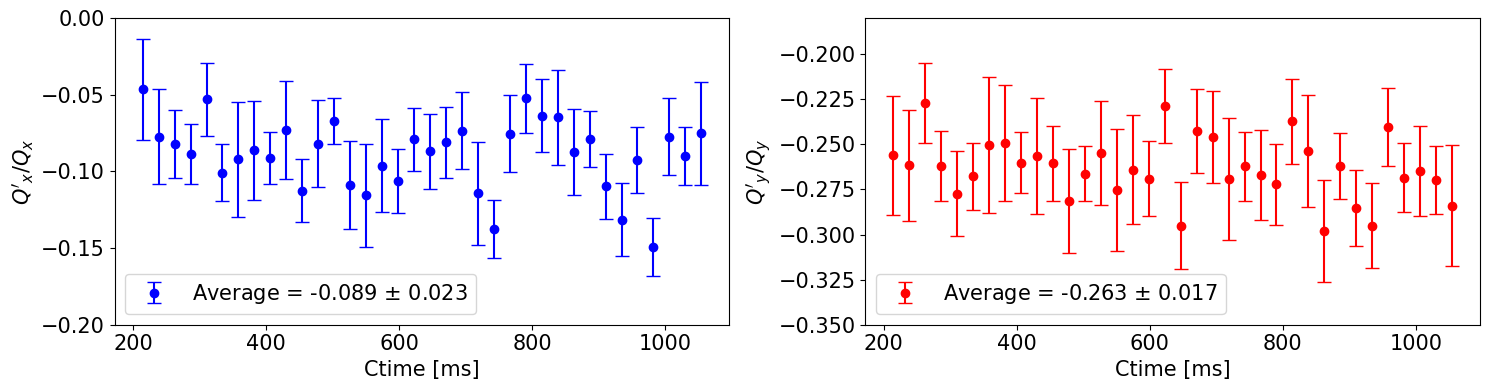

In [17]:
# Plot chroma evolution
f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"Ctime [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q'_x / Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df3_reshaped.index,
    df3_reshaped["linear_chroma_H"] / qx0,
    yerr=df3_reshaped["linear_chroma_H_err"] / qx0,
    fmt="o",
    capsize=5,
    color="blue",
    label=rf"Average = {np.nanmean(df3_reshaped['linear_chroma_H']) / qx0:.3f} $\pm$ {np.nanstd(df3_reshaped['linear_chroma_H']) / qx0:.3f}",
)

ax.legend(fontsize=fontsize)
ax.set_ylim(-0.2, -0.0)

ax = axs[1]
ax.set_xlabel(r"Ctime [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q'_y / Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df3_reshaped.index,
    df3_reshaped["linear_chroma_V"] / qy0,
    yerr=df3_reshaped["linear_chroma_H_err"] / qy0,
    fmt="o",
    capsize=5,
    color="red",
    label=rf"Average = {np.nanmean(df3_reshaped['linear_chroma_V']) / qy0:.3f} $\pm$ {np.nanstd(df3_reshaped['linear_chroma_V']) / qy0:.3f}",
)

ax.legend(fontsize=fontsize)
ax.set_ylim(-0.35, -0.18)

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"linchroma_evolution_20250822_HV_dpp_pm4e-3_MD1.{ext}", dpi=300)